In [8]:
# Import the required Python packages
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

# The goal

The goal is to show that you can detect edges in a image using changes in pixel intensity

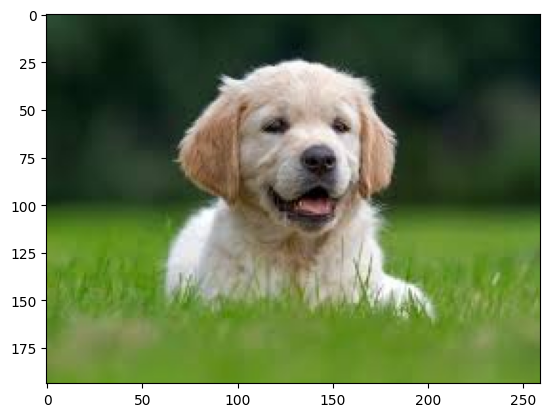

In [9]:
# Display the image from the specified path
img = plt.imread('images/01-dog.jpeg')
plt.imshow(img)
plt.show()

# What is an edge?

An edge occurs where there is a sudden change in pixel intensity

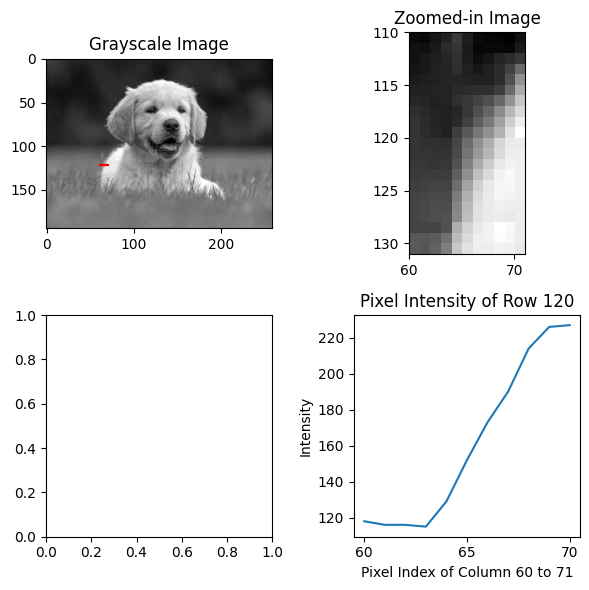

In [10]:
# Convert the image to grayscale
## Extract the Red, Green, and Blue channels
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
## Apply the grayscale conversion formula
## Based on https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#color_convert_rgb_gray
gray_img = (0.299 * R + 0.587 * G + 0.114 * B).astype(np.uint8)

# Select a row to plot the pixel intensity
row_index = 120
col_start = 60
width = 10
col_end = col_start + width + 1

# Extract the zoomed-in region from the grayscale image
zoom_row_start = row_index - 10
zoom_row_end = row_index + 10 + 1
zoom_col_start = col_start
zoom_col_end = col_end
zoomed_img = gray_img[zoom_row_start:zoom_row_end, zoom_col_start:zoom_col_end]

pixel_intensity = gray_img[row_index, col_start:col_end]

# Plot the grayscale image and pixel intensity side by side
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

# Display the grayscale image
axes[0, 0].imshow(gray_img, cmap='gray')
axes[0, 0].set_title('Grayscale Image')
patch = plt.Rectangle((col_start, row_index), width, 1, color='red', fill=False)
axes[0, 0].add_patch(patch)

# Display the zoomed-in image
axes[0, 1].imshow(zoomed_img, cmap='gray', extent=(col_start, col_end, zoom_row_end, zoom_row_start))
axes[0, 1].set_title('Zoomed-in Image')

# Plot the pixel intensity
axes[1, 1].plot(pixel_intensity)
axes[1, 1].set_title(f'Pixel Intensity of Row {row_index}')
# Set custom x-axis labels
xticks = range(0, len(pixel_intensity), 5)
axes[1, 1].set_xticks(xticks)
axes[1, 1].set_xticklabels(range(col_start, col_end, 5))
axes[1, 1].set_xlabel(f'Pixel Index of Column {col_start} to {col_end}')
axes[1, 1].set_ylabel('Intensity')

plt.tight_layout()
plt.show()

## Why use first derivative to show an edge?

### Understanding Image Edges
An edge in an image represents a significant change in pixel intensity. This change can be due to various factors like changes in color, texture, or brightness. Detecting these edges is crucial for many image processing tasks, such as object detection, image segmentation, and more.

### First Derivative and Edge Detection
The first derivative of a function measures the rate of change of that function. When applied to an image, the first derivative measures the rate of change of pixel intensities. Here's why this is useful for edge detection:

1. Constant Regions: In regions where the pixel intensity is constant (i.e., no change), the first derivative will be zero.
2. Gradual Changes: In regions where the pixel intensity changes gradually, the first derivative will have small values.
3. Sharp Changes (Edges): At points where there is a sudden change in pixel intensity (i.e., an edge), the first derivative will have a large value.

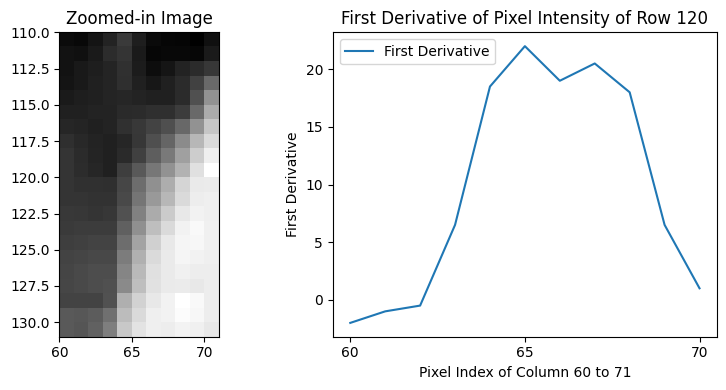

In [11]:
# Compute the first derivative of the pixel intensity
first_derivative = np.gradient(pixel_intensity)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the zoomed-in image
axes[0].imshow(zoomed_img, cmap='gray', extent=(col_start, col_end, zoom_row_end, zoom_row_start))
axes[0].set_title('Zoomed-in Image')

# Plot the first derivative
axes[1].plot(first_derivative, label='First Derivative')
axes[1].set_title(f'First Derivative of Pixel Intensity of Row {row_index}')
# Set custom x-axis labels
xticks = range(0, len(pixel_intensity), 5)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(range(col_start, col_end, 5))
axes[1].set_xlabel(f'Pixel Index of Column {col_start} to {col_end}')
axes[1].set_ylabel('First Derivative')
axes[1].legend()

plt.tight_layout()
plt.show()

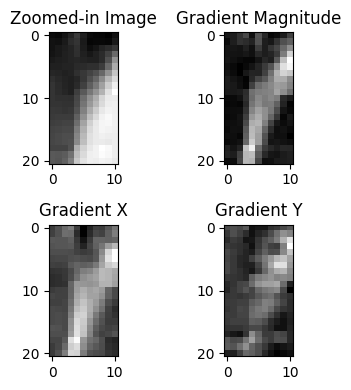

In [12]:
# Compute the gradients using np.gradient
grad_y, grad_x = np.gradient(zoomed_img.astype(np.float64))

# Compute the gradient magnitude
grad = np.sqrt(grad_x**2 + grad_y**2)

# Function to annotate each pixel with its value
def annotate_pixels(ax, data):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      ax.text(j, i, int(data[i, j]), ha='center', va='center', color='red')

# Plot the original and Sobel-applied matrices
fig, axes = plt.subplots(2, 2, figsize=(4, 4))

axes[0, 0].imshow(zoomed_img, cmap='gray')
axes[0, 0].set_title('Zoomed-in Image')
# annotate_pixels(axes[0, 0], zoomed_img)

axes[0, 1].imshow(grad, cmap='gray')
axes[0, 1].set_title('Gradient Magnitude')
# annotate_pixels(axes[0, 1], grad)

axes[1, 0].imshow(grad_x, cmap='gray')
axes[1, 0].set_title('Gradient X')
# annotate_pixels(axes[1, 0], grad_x)

axes[1, 1].imshow(grad_y, cmap='gray')
axes[1, 1].set_title('Gradient Y')
# annotate_pixels(axes[1, 1], grad_y)

plt.tight_layout()
plt.show()

# What is a Sobel Operator?

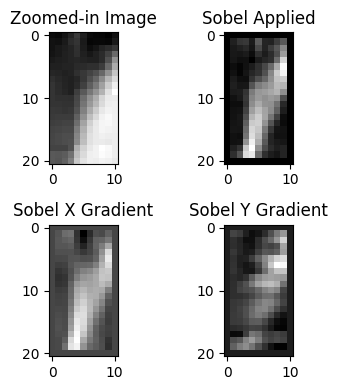

In [13]:
# Define the Sobel operators
# kernel $G_x$
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

# kernel $G_y$
sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

# Initialize the result matrix
sobel_applied = np.zeros_like(zoomed_img)

# Apply the Sobel operator to each 2D slice
grad_x = np.zeros_like(zoomed_img, dtype=np.float64) # To avoid overflow
grad_y = np.zeros_like(zoomed_img, dtype=np.float64)

# Convolve with Sobel x and y operators
# To avoid boundary issues, we skip the first and last rows and columns
# The Sobel operator requires a 3x3 region around each pixel to compute the gradient,
# and this cannot be done for the pixels at the edges of the image.
for row in range(1, zoomed_img.shape[0] - 1):
  for col in range(1, zoomed_img.shape[1] - 1):
    region = zoomed_img[row-1:row+2, col-1:col+2]
    grad_x[row, col] = np.sum(region * sobel_x) # Element-wise multiplication and summation
    grad_y[row, col] = np.sum(region * sobel_y)

# Compute the gradient magnitude
sobel_applied = np.sqrt(grad_x**2 + grad_y**2)

# Function to annotate each pixel with its value
def annotate_pixels(ax, data):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      ax.text(j, i, int(data[i, j]), ha='center', va='center', color='red')

# Plot the original and Sobel-applied matrices
fig, axes = plt.subplots(2, 2, figsize=(4, 4))

axes[0, 0].imshow(zoomed_img, cmap='gray')
axes[0, 0].set_title('Zoomed-in Image')
# annotate_pixels(axes[0, 0], zoomed_img)

axes[0, 1].imshow(sobel_applied, cmap='gray')
axes[0, 1].set_title(f'Sobel Applied')
# annotate_pixels(axes[0, 1], sobel_applied)

axes[1, 0].imshow(grad_x, cmap='gray')
axes[1, 0].set_title(f'Sobel X Gradient')
# annotate_pixels(axes[1, 0], grad_x)

axes[1, 1].imshow(grad_y, cmap='gray')
axes[1, 1].set_title(f'Sobel Y Gradient')
# annotate_pixels(axes[1, 1], grad_y)

plt.tight_layout()
plt.show()

# Applying Sobel to Real Image

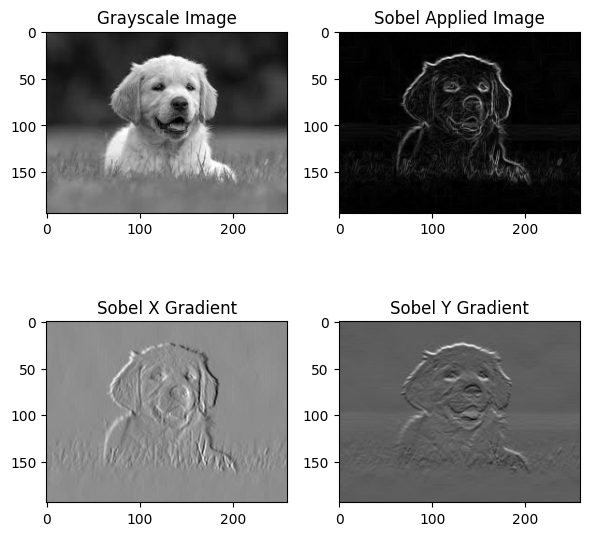

In [14]:
def rgb2Gray(src: npt.ArrayLike) -> tuple[npt.ArrayLike, int]:
  # Convert the image to grayscale
  ## Extract the Red, Green, and Blue channels
  R = img[:, :, 0]
  G = img[:, :, 1]
  B = img[:, :, 2]
  ## Apply the grayscale conversion formula
  ## Based on https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#color_convert_rgb_gray
  gray_img = (0.299 * R + 0.587 * G + 0.114 * B).astype(np.uint8)

  # Check if image is loaded fine
  if src is None:
    print ('Error opening image')
    return np.empty((0,0), dtype=np.uint8), -1

  return gray_img, 0

# kernel $G_x$
SOBEL_X = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

# kernel $G_y$
SOBEL_Y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

def sobel(src: npt.ArrayLike) -> tuple[dict[str, npt.ArrayLike], int]:
  # Check if image is loaded fine
  if src is None:
    print ('Error opening image')
    return {}, -1
  
  gray_img, err = rgb2Gray(src) # matrix
  if err != 0:
    print('Error converting image to grayscale')
    return {}, -1

  # Initialize the result matrix
  sobel_applied = np.zeros_like(gray_img)

  # Apply the Sobel operator to each 2D slice
  grad_x = np.zeros_like(gray_img, dtype=np.float64) # To avoid overflow
  grad_y = np.zeros_like(gray_img, dtype=np.float64)

  # Convolve with Sobel x and y operators
  # To avoid boundary issues, we skip the first and last rows and columns
  # The Sobel operator requires a 3x3 region around each pixel to compute the gradient,
  # and this cannot be done for the pixels at the edges of the image.
  for row in range(1, gray_img.shape[0] - 1):
    for col in range(1, gray_img.shape[1] - 1):
      region = gray_img[row-1:row+2, col-1:col+2]
      grad_x[row, col] = np.sum(region * SOBEL_X) # Element-wise multiplication and summation
      grad_y[row, col] = np.sum(region * SOBEL_Y)

  # Compute the gradient magnitude
  sobel_applied = np.sqrt(grad_x**2 + grad_y**2)
  
  return {
    'gray_img': gray_img,
    'grad_x': grad_x,
    'grad_y': grad_y,
    'sobel_applied': sobel_applied,
  }, 0

ok, err = sobel(img)

# Plot the original and Sobel-applied matrices
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].imshow(ok['gray_img'], cmap='gray')
axes[0, 0].set_title(f'Grayscale Image')

axes[0, 1].imshow(ok['sobel_applied'], cmap='gray')
axes[0, 1].set_title(f'Sobel Applied Image')

axes[1, 0].imshow(ok['grad_x'], cmap='gray')
axes[1, 0].set_title(f'Sobel X Gradient')

axes[1, 1].imshow(ok['grad_y'], cmap='gray')
axes[1, 1].set_title(f'Sobel Y Gradient')

plt.tight_layout()
plt.show()